In [1]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import csv
import pdb
import os
import matplotlib.pyplot as plt
import timeit
from joblib import dump, load

In [2]:
def load_data(directory, target_var):
    print("Loading data")
    full_data = []
    file_names = []
    if directory[-1] != '/':
        directory = directory + '/'
    for root,dir,files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                filepath = directory + file
#                 print('Loading: ', file)
                csv_data = np.genfromtxt(filepath, delimiter=',')
                full_data.append(csv_data)
                file_names.append(file)
    features = np.vstack(full_data)
    ground_truth = features[:,target_var]
    features = np.delete(features, target_var, axis=1)
    
    return features, ground_truth, full_data, file_names
    

In [3]:
def load_data_cv(directory, target_var):
    print("Loading data")
    full_data = []
    file_names = []
    ground_truth = []
    features = []
    if directory[-1] != '/':
        directory = directory + '/'
    for root,dir,files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                filepath = directory + file
                print('Loading: ', file)
                csv_data = np.genfromtxt(filepath, delimiter=',')
                full_data.append(csv_data)
                file_names.append(file)
    for file in range(0,len(full_data)):
        ground_truth.append(full_data[file][:,target_var])
        features.append(np.delete(full_data[file], target_var, axis=1))
    
    return features, ground_truth, file_names

In [4]:
def load_file(filepath, target_var):
    csv_data = np.genfromtxt(filepath, delimiter=',')
    ground_truth = csv_data[:, target_var]
    features = np.delete(csv_data, target_var, axis=1)

    return features, ground_truth

In [5]:
truth_index = 2
start = timeit.default_timer()
cv_features, cv_truth, cv_file_names = load_data_cv('/mnt/d/git/heat_chamber_code/jupyter/real_cross_validation/', truth_index)

Loading data
Loading:  max40_kalman.csv
Loading:  max60run1_kalman.csv
Loading:  max60run2_kalman.csv


In [6]:
train_set_features = []
train_set_truth = []
train_features = []
train_truth = []
num_runs = len(cv_features)
# Build leave one hold out training sets
for test_run in range(0,num_runs):
    for train_run in range(0, num_runs):
        if test_run != train_run:
            train_features.append(cv_features[train_run])
            train_truth.append(cv_truth[train_run])
    train_set_truth.append(np.hstack(train_truth))
    train_set_features.append(np.vstack(train_features))
    train_truth = []
    train_features = []

In [7]:
forest = RandomForestRegressor(random_state=42)
score = []
prediction_array = []
truth_array = []
error_array = []
for run in range(0,num_runs):
    forest.fit(train_set_features[run], train_set_truth[run])
    score.append(forest.score(cv_features[run], cv_truth[run]))
    run_predictions = []
    run_truth = []
    temp_err = []
    index = 0
    for sample in range(0, len(cv_features[run])):
        prediction = forest.predict([cv_features[run][sample]])
        run_predictions.append(prediction)
        temp_err.append(100*abs((cv_truth[run][sample] - prediction)/cv_truth[run][sample]))
        index = index + 1
    run_predictions = np.vstack(run_predictions)
    error_array.append(np.vstack(temp_err))
    prediction_array.append(run_predictions)
    truth_array.append(cv_truth[run])
    

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [8]:
average_score = str(np.average(score))
print('Cross validation score: ' + average_score)

Cross validation score: -1.6386313719922558


Score: -6.719685590899622


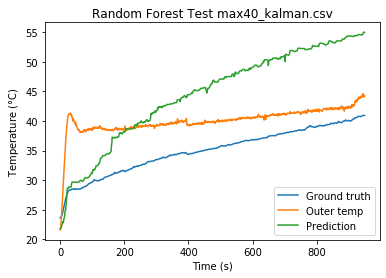

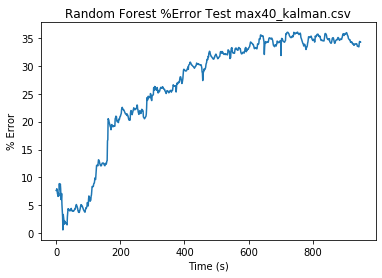

Score: 0.960786782312438


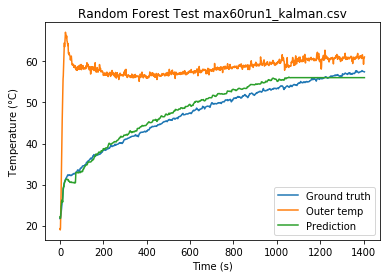

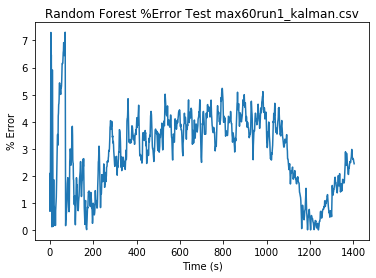

Score: 0.8430046926104167


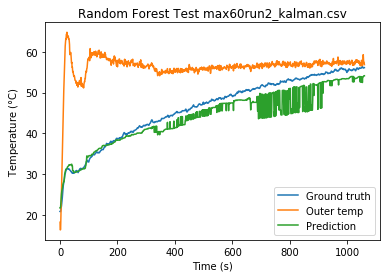

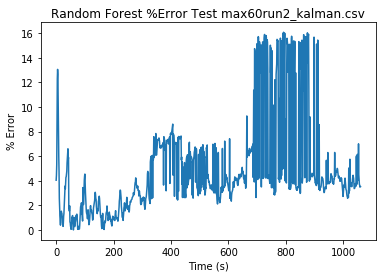

Time:  2.24668709999969


In [9]:
for i in range(0,num_runs):
    score_str = str(score[i])
    print('Score: ' + score_str)
    plt.figure
    plt.plot(range(len(truth_array[i])), truth_array[i], label="Ground truth")
    plt.plot(range(len(truth_array[i])), cv_features[i][:,1], label="Outer temp")
    plt.plot(range(len(truth_array[i])), prediction_array[i], label="Prediction")
    plt.legend(loc="lower right")
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature ($\degree$C)')
    plt.title('Random Forest Test ' + cv_file_names[i])
    plt.show()
    plt.figure
    plt.plot(range(len(error_array[i])), error_array[i])
    plt.xlabel('Time (s)')
    plt.ylabel('% Error')
    plt.title('Random Forest %Error Test ' + cv_file_names[i])
    plt.show()

stop = timeit.default_timer()
print('Time: ', stop - start)  